In [31]:
import numpy as np
import os
from pprint import pprint
from collections import defaultdict
import seq_helper as seqh
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from matplotlib.cm import spectral
import matplotlib.pyplot as plt

In [32]:
with_N = False

In [33]:
# read data
dirname = ''.join(['./pre_process_dataset/'])
file_list = []
fm_set = set()
Q_set = set()
label = []

name_image_dict = {}
for name in os.listdir(dirname):    
    file_path_name = ''.join(['./pre_process_dataset/',name])    
    data = (seqh.read_from_file(file_path_name))   
    
    Q_hist = set(data[0].keys())        
    Q_set.update(Q_hist)    
        
    fm_hist = data[1]
    
    if not with_N:
        # collect what to remove    
        fm_to_remove = []
        for fm in fm_hist.keys():
            if 'N' in fm:
                fm_to_remove.append(fm)

        # remove it
        for i in fm_to_remove:
            fm_hist.pop(i, None)
           
    # collect unique
    fm_set.update(set(fm_hist.keys()))

    label.append(float(data[2]))
    
    file_list.append(data)

label = np.array(label)

In [34]:
# format data into matrix
data_num = len(file_list)

Q_dim = len(Q_set)
Q_index = [i for i in range(Q_dim)]
Q_name = list(Q_set)
Q_name_index_dict = dict(zip(Q_name, Q_index))

fm_dim = len(fm_set)
fm_index = [i for i in range(fm_dim)]  #for the dict to matrix mapping
fm_name = list(fm_set)
fm_name_index_dict = dict(zip(fm_name, fm_index))

Q = np.zeros((data_num, Q_dim))    #Q quality matrix, shape num_data, dim
F = np.zeros((data_num, fm_dim))   #4-mer matrix, shape num_data, dim

for i in range(data_num):
    data = file_list[i]
    Q_hist = data[0]
    fm_hist = data[1]
    data_Q_num = np.sum(np.array(list(Q_hist.values())))
    data_fm_num = np.sum(np.array(list(fm_hist.values())))    
    
    for key, value in Q_hist.items():
        j = Q_name_index_dict[key]
        Q[i,j] = value/data_Q_num       #normalization
        
    for key, value in fm_hist.items():
        j = fm_name_index_dict[key]
        F[i,j] = value/data_fm_num      #normalization
    

In [35]:
#read fragment file
import numpy as np
tmpData = np.genfromtxt('matrix_data/fragLenOutput.txt',delimiter='\t',dtype=float)

#length file
L = np.delete(tmpData,0,1)
for i in range(0,len(L)):
    curSum = np.sum(L[i])
    for j in range(0,len(L[i])):
        tmp = float(L[i][j]) / float(curSum)
        L[i][j] = tmp

In [36]:
#Q is quality file
#F is 4-mer file
#L is fragment length file
# logistic regression, 0.6 training, 0.2 validation, 0.2 testing
Q_train, Q_test, F_train, F_test, L_train, L_test, label_train, label_test = \
    train_test_split(Q,F,L,label,test_size=0.4, random_state=42)
    
Q_valid, Q_test, F_valid, F_test, L_valid, L_test, label_valid, label_test = \
    train_test_split(Q_test,F_test,L_test, label_test,test_size=0.5, random_state=42)

C = 100000000000 # large C -> no regularization
logistic_regr = LogisticRegression(penalty='l2', C=C) 

val_pred_list = []
logistic_regr.fit(Q_train, label_train)

#Quality score
# on validation set    
valid_pred = (logistic_regr.predict(Q_valid))
valid_pred_l = list((valid_pred.astype('float')).astype('int'))
label_valid_l = list((label_valid.astype('float')).astype('int'))

print("Results on validation set using quality score\n")
seqh.evaluate_result(label_valid_l, valid_pred_l)

Results on validation set using quality score

accuracy:  0.875
precision:  0.882352941176
recall:  0.857142857143
[[30  5]
 [ 4 33]]


Results on test set using quality score

accuracy:  0.805555555556
precision:  0.794871794872
recall:  0.837837837838
[[31  6]
 [ 8 27]]


/Users/Fan/anaconda/lib/python3.5/site-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


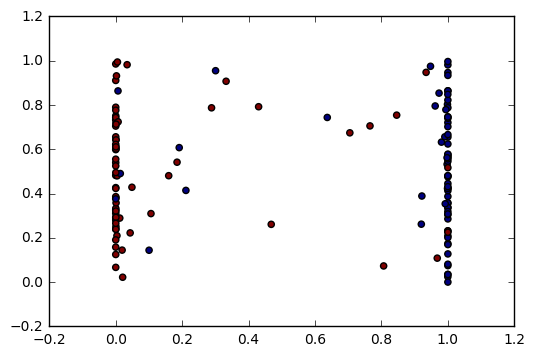

In [37]:
# on test set    
test_pred = (logistic_regr.predict(Q_test))
test_pred_l = list((test_pred.astype('float')).astype('int'))
label_test_l = list((label_test.astype('float')).astype('int'))

print("Results on test set using quality score\n")

seqh.evaluate_result(label_test_l, test_pred_l)

#the probabilties that each dataset belongs in each class
probs = logistic_regr.predict_proba(Q_test)

#plot the probability 
plt.scatter(probs[:,0],np.random.rand(72),c=label_test)
plt.show()

In [38]:
C = 100000000000 # large C -> no regularization
logistic_regr = LogisticRegression(penalty='l2', C=C) 

val_pred_list = []
logistic_regr.fit(F_train, label_train)

# 4-mer
# on validation set    
valid_pred = (logistic_regr.predict(F_valid))
valid_pred_l = list((valid_pred.astype('float')).astype('int'))
label_valid_l = list((label_valid.astype('float')).astype('int'))

print("Results on validation set using 4-mer\n")

seqh.evaluate_result(label_valid_l, valid_pred_l)

Results on validation set using 4-mer

accuracy:  0.958333333333
precision:  1.0
recall:  0.914285714286
[[32  3]
 [ 0 37]]


Results on validation set using 4-mer score

accuracy:  0.972222222222
precision:  1.0
recall:  0.945945945946
[[35  2]
 [ 0 35]]


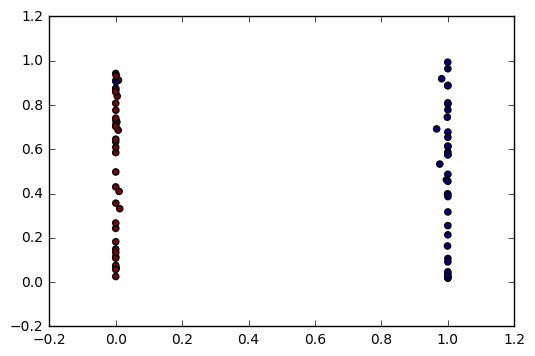

In [39]:
# 4-mer
# on test set    
test_pred = (logistic_regr.predict(F_test))
test_pred_l = list((test_pred.astype('float')).astype('int'))
label_test_l = list((label_test.astype('float')).astype('int'))

#the probabilties that each dataset belongs in each class
probs = logistic_regr.predict_proba(F_test)

print("Results on validation set using 4-mer score\n")

seqh.evaluate_result(label_test_l, test_pred_l)

#plot the probability 
plt.scatter(probs[:,0],np.random.rand(72),c=label_test)
plt.show()

In [40]:
C = 100000000000 # large C -> no regularization
logistic_regr = LogisticRegression(penalty='l2', C=C) 

val_pred_list = []
logistic_regr.fit(L_train, label_train)

# fragment length
# on validation set    
valid_pred = (logistic_regr.predict(L_valid))
valid_pred_l = list((valid_pred.astype('float')).astype('int'))
label_valid_l = list((label_valid.astype('float')).astype('int'))

print("Results on validation set using fragment length\n")

seqh.evaluate_result(label_valid_l, valid_pred_l)

Results on validation set using fragment length

accuracy:  0.875
precision:  0.861111111111
recall:  0.885714285714
[[31  4]
 [ 5 32]]


Results on test set using 4-mer score

accuracy:  0.833333333333
precision:  0.857142857143
recall:  0.810810810811
[[30  7]
 [ 5 30]]


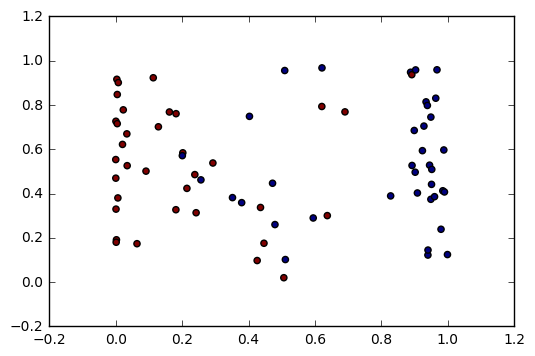

In [41]:
# fragment length
# on test set    
test_pred = (logistic_regr.predict(L_test))
test_pred_l = list((test_pred.astype('float')).astype('int'))
label_test_l = list((label_test.astype('float')).astype('int'))

probs = logistic_regr.predict_proba(L_test)

print("Results on test set using 4-mer score\n")

seqh.evaluate_result(label_test_l, test_pred_l)

#plot the probability 
plt.scatter(probs[:,0],np.random.rand(72),c=label_test)
plt.show()

In [42]:
#concatenate all of the features together
tmpA = np.concatenate((Q,L),axis=1)
A = np.concatenate((tmpA,F),axis=1)

# logistic regression, 0.6 training, 0.2 validation, 0.2 testing
A_train, A_test, label_train, label_test = \
    train_test_split(A,label,test_size=0.4, random_state=42)
    
A_valid, A_test, label_valid, label_test = \
    train_test_split(A_test, label_test,test_size=0.5, random_state=42)

C = 100000000000 # large C -> no regularization
logistic_regr = LogisticRegression(penalty='l2', C=C) 

val_pred_list = []
logistic_regr.fit(A_train, label_train)

# fragment length
# on validation set    
valid_pred = (logistic_regr.predict(A_valid))
valid_pred_l = list((valid_pred.astype('float')).astype('int'))
label_valid_l = list((label_valid.astype('float')).astype('int'))

print("Results on validation set using fragment length\n")

seqh.evaluate_result(label_valid_l, valid_pred_l)

Results on validation set using fragment length

accuracy:  0.958333333333
precision:  1.0
recall:  0.914285714286
[[32  3]
 [ 0 37]]


In [43]:
# All features concatendated 
# on test set    
test_pred = (logistic_regr.predict(A_test))
test_pred_l = list((test_pred.astype('float')).astype('int'))
label_test_l = list((label_test.astype('float')).astype('int'))

probs = logistic_regr.predict_proba(A_test)

print("Results on test set using all features score\n")

seqh.evaluate_result(label_test_l, test_pred_l)

#plot the probability 
plt.scatter(probs[:,0],np.random.rand(72),c=label_test)
#plt.show()

Results on test set using all features score

accuracy:  0.958333333333
precision:  0.972222222222
recall:  0.945945945946
[[35  2]
 [ 1 34]]


In [44]:
#run SVM of input file containing all features
from sklearn.svm import SVC

clf = SVC(kernel='linear', C=10000000)
clf.fit(A_train, label_train)

# fragment length
# on validation set    
valid_pred = (clf.predict(A_valid))
valid_pred_l = list((valid_pred.astype('float')).astype('int'))
label_valid_l = list((label_valid.astype('float')).astype('int'))

print("Results on validation set using fragment length (SVM)\n")

seqh.evaluate_result(label_valid_l, valid_pred_l)

Results on validation set using fragment length (SVM)

accuracy:  0.944444444444
precision:  1.0
recall:  0.885714285714
[[31  4]
 [ 0 37]]


In [46]:
# All features concatendated 
# on test set    
test_pred = (clf.predict(A_test))
test_pred_l = list((test_pred.astype('float')).astype('int'))
label_test_l = list((label_test.astype('float')).astype('int'))

#probs = clf.predict_proba(A_test)

print("Results on test set using all features score\n")

seqh.evaluate_result(label_test_l, test_pred_l)

#plot the probability 
#plt.scatter(probs[:,0],np.random.rand(72),c=label_test)

Results on test set using all features score

accuracy:  0.958333333333
precision:  0.972222222222
recall:  0.945945945946
[[35  2]
 [ 1 34]]


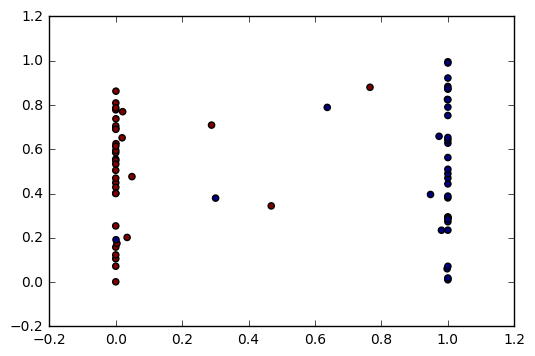

In [50]:
plt.scatter(probs[:,0],np.random.rand(72),c=label_test)
plt.show()

In [14]:
# save data
if with_N:
    F_name = 'F_with_N.csv'
else:
    F_name = 'F.csv'
Q_name = 'Q.csv'
L_name = 'L.csv'
F_save = ''.join(['./matrix_data/', F_name])
np.savetxt(F_save, F, delimiter=",")
Q_save = ''.join(['./matrix_data/', Q_name])
np.savetxt(Q_save, Q, delimiter=",")
L_save = ''.join(['./matrix_data/', L_name])
L = np.array(label).astype(np.float)
np.savetxt(L_save, L, delimiter=",")